# Simple LSTM examples

This notebook was heavily inspired (read we took the whole thing) by the notebooks in the lecture series "Machine Learning for Physicists" by Florian Marquardt. See https://machine-learning-for-physicists.org. As with the original work this notebook is also released under the Sharealike License https://creativecommons.org/licenses/by-sa/4.0/

In this notebook we will do the following
- train a recurrent (LSTM) network to recall a number when asked
- train a recurrent (LSTM) netowrk to countdown


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

from scipy import linalg

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.18.0


# Example 1: Recall-Net

A network that can recall a number (that it has been told before), when asked to do so!

In [2]:
def init_recall_net(timesteps):
    #Make our new sequential network
    rnn = keras.models.Sequential()

    #Add input layer
    rnn.add(keras.layers.InputLayer(batch_input_shape=(None, timesteps, 3)))
    
    #Add two LSTM layers
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    rnn.add(keras.layers.LSTM(5, return_sequences=True))
    rnn.add(keras.layers.LSTM(2, return_sequences=True))
    
    #Compile the network
    rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return rnn

In [3]:
def produce_batch(batchsize,timesteps):
    
    observations=np.zeros([batchsize,timesteps,3])
    desired_output=np.zeros([batchsize,timesteps,2])
    
    tell_position=np.random.randint(int(timesteps/2),size=batchsize)
    ask_position=int(timesteps/2)+1+np.random.randint(int(timesteps/2)-1,size=batchsize)
    
    # mark input-slot 0 with 1 at the tell_position:
    observations[range(batchsize),tell_position,0]=1
    # write the value to be memorized into input-slot 1
    memorize_numbers=np.random.random(batchsize)
    observations[range(batchsize),tell_position,1]=memorize_numbers
    # mark input-slot 2 with 1 at the ask_position
    observations[range(batchsize),ask_position,2]=1
    
    desired_output[range(batchsize),ask_position,0]=memorize_numbers
    return(observations,desired_output)

In [4]:
#Test the bacth production function
timesteps=5
batchsize=1
test_observations,test_target=produce_batch(batchsize,timesteps)
print("Observations\n",test_observations)
print("Target\n",test_target)



Observations
 [[[1.         0.55359853 0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         1.        ]
  [0.         0.         0.        ]]]
Target
 [[[0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]
  [0.55359853 0.        ]
  [0.         0.        ]]]


So the network needs to read the first column to find out which number in the second column to remember, then it needs to read the third column to find out which row it needs to recall that number in.

In [5]:
timesteps=20
rnn=init_recall_net(timesteps)

batchsize=1
test_observations,test_target=produce_batch(batchsize,timesteps)

batchsize=20
epochs=300

test_output=np.zeros([timesteps,epochs])

for k in range(epochs):
    input_observations,output_targets=produce_batch(batchsize,timesteps)
    rnn.train_on_batch(input_observations,output_targets)
    test_output[:,k]=rnn.predict_on_batch(test_observations)[0,:,0]
    print("epoch: ", k, " deviation: ", "{:1.3f}".format(sum((test_output[:,k]-test_target[0,:,0])**2)), end="      \r")



epoch:  299  deviation:  0.356      

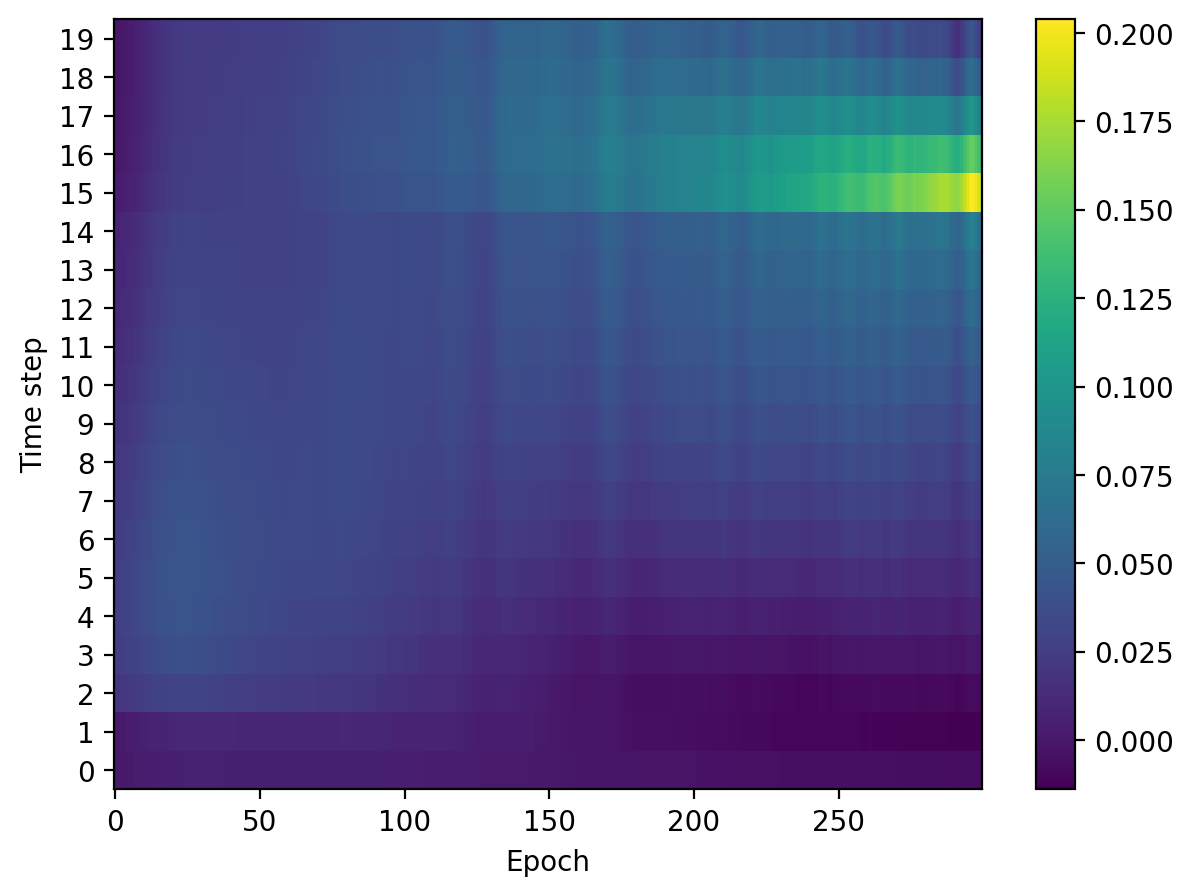

In [6]:
fig,ax=plt.subplots(figsize=(7,5))
im=ax.imshow(test_output,origin='lower',interpolation='nearest',aspect='auto')
ax.set_xlabel("Epoch")
ax.set_ylabel("Time step")
ax.set_yticks(np.arange(timesteps))
cb = fig.colorbar(im)

So here time (in the 20 step sequence) runs up the screen, whilst our time (measured in number fo training epochs) runs across the screen. The LSTM network gets better at only returning a value in the desired location but there is some tail bleeding into higher timesteps.

Deviation:  [1.09520948e-03 5.05602341e-03 1.04065028e-02 1.40136006e-02
 1.54086947e-02 1.49711899e-02 1.29355096e-02 1.27044827e-02
 1.22968653e-02 1.20885337e-02 1.69248609e-02 4.56450525e-01
 7.34074736e-02 7.53332254e-02 9.77608201e-01 3.07285843e-01
 6.45714416e-01 1.75261813e+00 9.85305733e-01 8.09861186e-01]


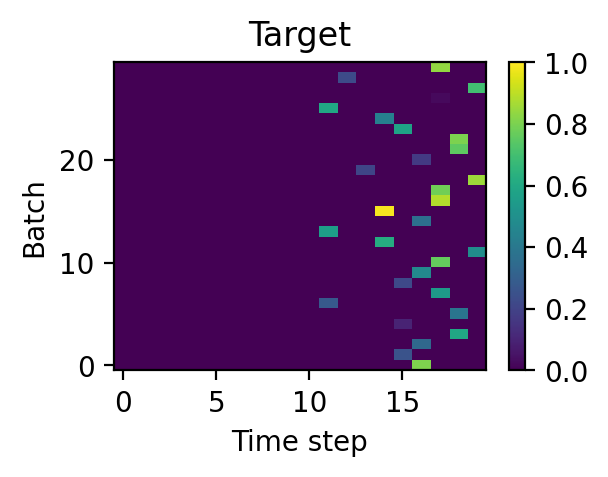

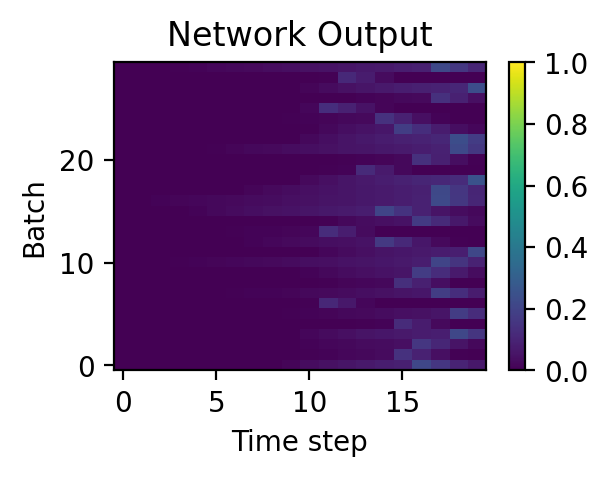

In [7]:
batchsize=30
test_observations,test_target=produce_batch(batchsize,timesteps)
test_output=np.zeros([batchsize,timesteps])

test_output[:,:]=rnn.predict_on_batch(test_observations)[:,:,0]

fig,ax=plt.subplots(figsize=(3,2))
im=ax.imshow(test_target[:,:,0],vmax=1.0,vmin=0.0,origin='lower',interpolation='nearest',aspect='auto')
cb=fig.colorbar(im)
ax.set_title("Target")
ax.set_xlabel("Time step")
ax.set_ylabel("Batch")

fig,ax=plt.subplots(figsize=(3,2))
im=ax.imshow(test_output,vmax=1.0,vmin=0.0,origin='lower',interpolation='nearest',aspect='auto')
cb=fig.colorbar(im)
ax.set_title("Network Output")
ax.set_xlabel("Time step")
ax.set_ylabel("Batch")

print("Deviation: ", sum((test_output-test_target[:,:,0])**2))

Here time within the sequence runs across the page and the (arbitrary) batch index runs up the page. You see the network gets hits in the right places but they bleed into the higher timesteps.

In [8]:
def produce_batch_tell_ask_twice(batchsize, timesteps):
    
    observations=np.zeros([batchsize,timesteps,3])
    desired_output=np.zeros([batchsize,timesteps,2])
    
    tell_position=np.random.randint(int(timesteps/2),size=batchsize)
    ask_position=int(timesteps/2)+1+np.random.randint(int(timesteps/4)-2,size=batchsize)
    ask_position2=ask_position+1+np.random.randint(int(timesteps/4)-2,size=batchsize)
    
    # mark input-slot 0 with 1 at the tell_position:
    observations[range(batchsize),tell_position,0]=1
    # write the value to be memorized into input-slot 1
    memorize_numbers=np.random.random(batchsize)
    observations[range(batchsize),tell_position,1]=memorize_numbers
    # mark input-slot 2 with 1 at the ask_position
    observations[range(batchsize),ask_position,2]=1
    observations[range(batchsize),ask_position2,2]=1
    
    desired_output[range(batchsize),ask_position,0]=memorize_numbers
    desired_output[range(batchsize),ask_position2,0]=memorize_numbers
    return(observations,desired_output)

Deviation:  [1.73949741e-03 6.72492773e-03 1.25447282e-02 1.66025198e-02
 1.80723272e-02 1.77624526e-02 1.58862888e-02 1.20749048e-02
 1.07531285e-02 1.09815719e-02 1.64200407e-02 1.59276234e+00
 2.94126626e+00 3.07390229e+00 2.19722985e+00 7.96704035e-01
 6.77742558e-01 7.61021007e-02 1.25140892e-01 1.62008968e-01]


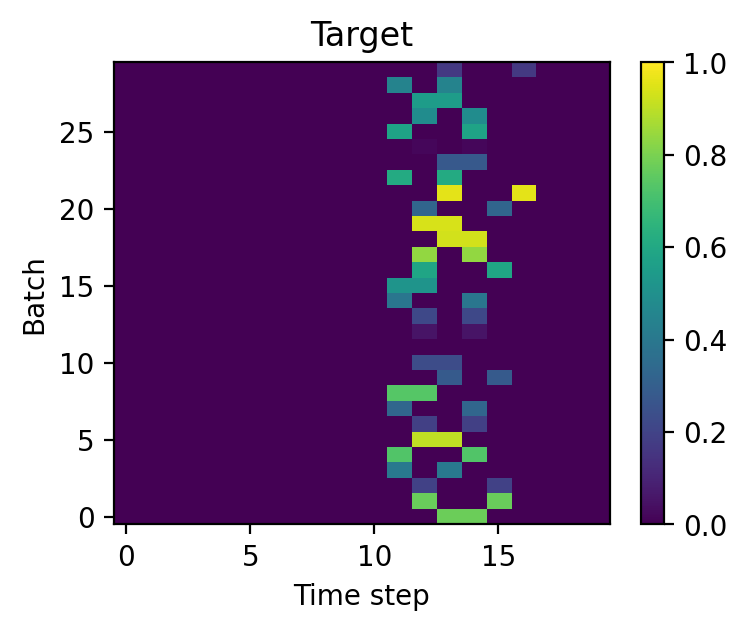

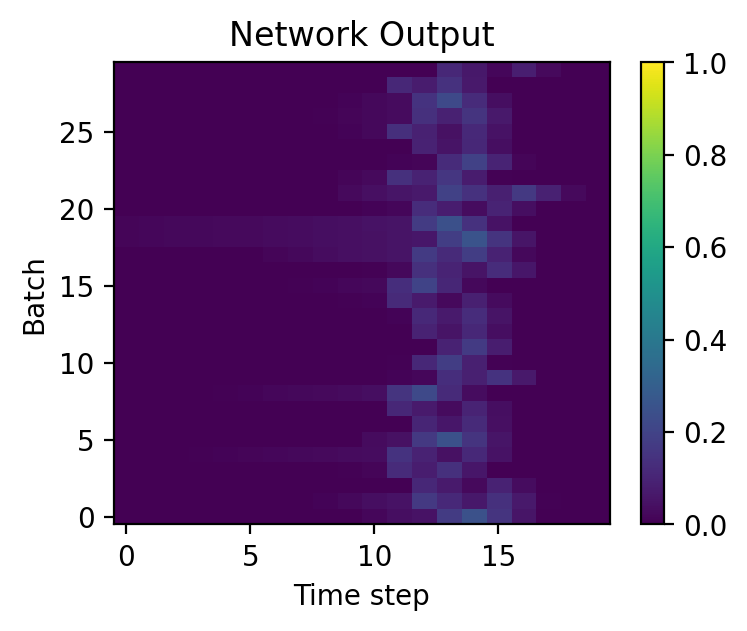

In [9]:
batchsize=30
test_observations,test_target=produce_batch_tell_ask_twice(batchsize,timesteps)
test_output=np.zeros([batchsize,timesteps])

test_output[:,:]=rnn.predict_on_batch(test_observations)[:,:,0]

fig,ax=plt.subplots(figsize=(4,3))
im=ax.imshow(test_target[:,:,0],vmax=1.0,vmin=0.0,origin='lower',interpolation='nearest',aspect='auto')
cb=fig.colorbar(im)
ax.set_title("Target")
ax.set_xlabel("Time step")
ax.set_ylabel("Batch")

fig,ax=plt.subplots(figsize=(4,3))
im=ax.imshow(test_output,vmax=1.0,vmin=0.0,origin='lower',interpolation='nearest',aspect='auto')
cb=fig.colorbar(im)
ax.set_title("Network Output")
ax.set_xlabel("Time step")
ax.set_ylabel("Batch")

print("Deviation: ", sum((test_output-test_target[:,:,0])**2))

## We need more memory
So we will use a deeper pool of LSTMs

In [10]:
def init_recall_net_powerful(timesteps):
    rnn = keras.models.Sequential()
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    rnn.add(keras.layers.InputLayer(batch_input_shape=(None, timesteps, 3)))

    #Only difference is the number of LSTMs in the first layer
    rnn.add(keras.layers.LSTM(20, return_sequences=True))
    rnn.add(keras.layers.LSTM(2, return_sequences=True))
    rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return rnn

In [11]:
timesteps=20
rnn=init_recall_net_powerful(timesteps)

batchsize=1
test_observations,test_target=produce_batch(batchsize,timesteps)

batchsize=20
epochs=300

test_output=np.zeros([timesteps,epochs])

for k in range(epochs):
    input_observations,output_targets=produce_batch(batchsize,timesteps)
    rnn.train_on_batch(input_observations,output_targets)
    test_output[:,k]=rnn.predict_on_batch(test_observations)[0,:,0]
    print("\r epoch: ", k, " deviation: ", sum((test_output[:,k]-test_target[0,:,0])**2), end="")


 epoch:  299  deviation:  0.064969524883331415

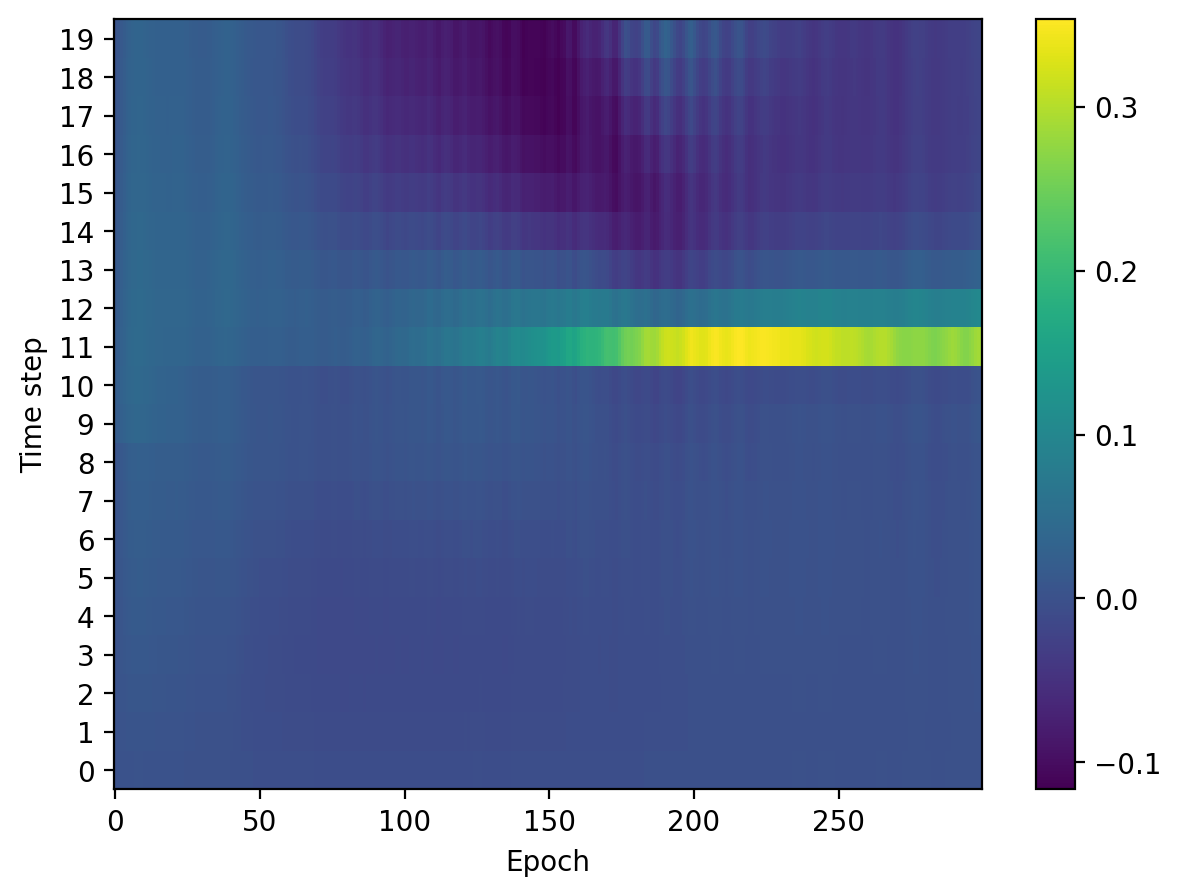

In [12]:
fig,ax=plt.subplots(figsize=(7,5))
im=ax.imshow(test_output,origin='lower',interpolation='nearest',aspect='auto')
ax.set_xlabel("Epoch")
ax.set_ylabel("Time step")
ax.set_yticks(np.arange(timesteps))
cb = fig.colorbar(im)

Deviation:  [3.66410267e-05 5.22353460e-05 3.51924169e-04 8.84641568e-04
 1.58547184e-03 2.46273658e-03 4.03087681e-03 5.83435624e-03
 7.84674477e-03 1.05912513e-02 1.43277213e-02 5.84723102e-01
 4.74360565e-01 2.03025250e-01 9.77574714e-02 4.96894872e-02
 4.49410582e-02 5.00095149e-02 6.53304816e-02 2.15506227e-01]


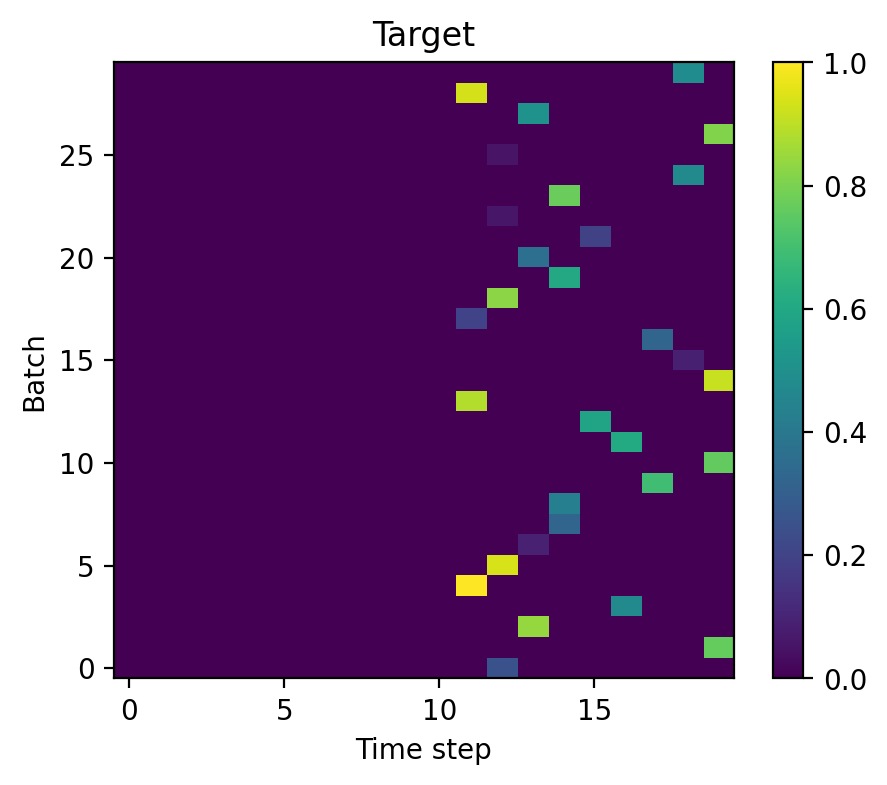

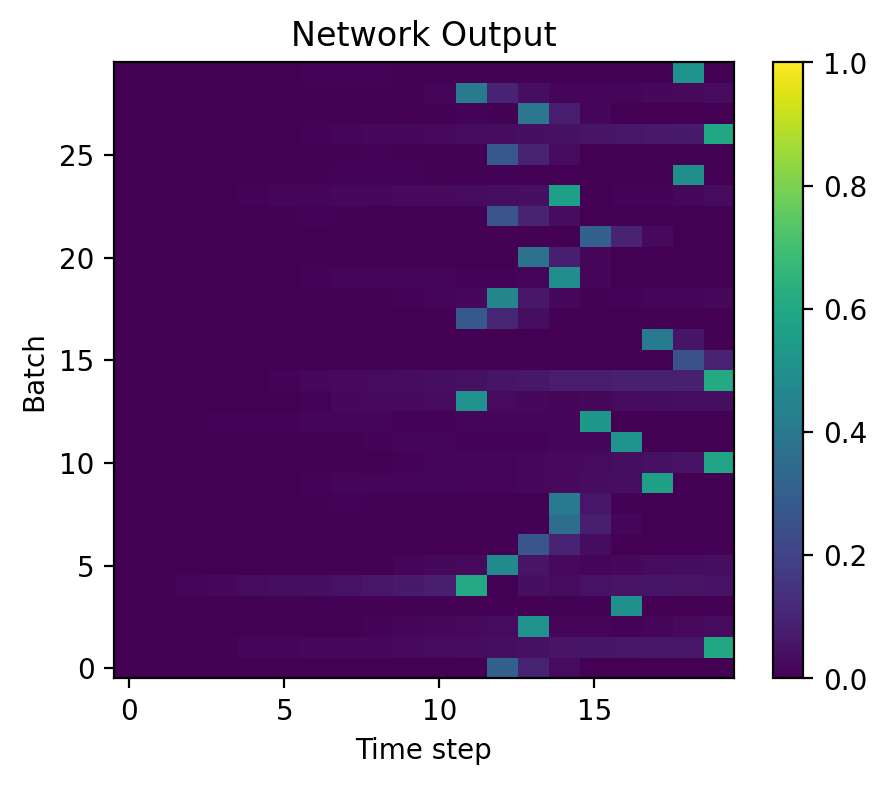

In [13]:
batchsize=30
test_observations,test_target=produce_batch(batchsize,timesteps)
test_output=np.zeros([batchsize,timesteps])

test_output[:,:]=rnn.predict_on_batch(test_observations)[:,:,0]

fig,ax=plt.subplots(figsize=(5,4))
im=ax.imshow(test_target[:,:,0],vmax=1.0,vmin=0.0,origin='lower',interpolation='nearest',aspect='auto')
cb=fig.colorbar(im)
ax.set_title("Target")
ax.set_xlabel("Time step")
ax.set_ylabel("Batch")

fig,ax=plt.subplots(figsize=(5,4))
im=ax.imshow(test_output,vmax=1.0,vmin=0.0,origin='lower',interpolation='nearest',aspect='auto')
cb=fig.colorbar(im)
ax.set_title("Network Output")
ax.set_xlabel("Time step")
ax.set_ylabel("Batch")


print("Deviation: ", sum((test_output-test_target[:,:,0])**2))

With the deeper memoery there is muuch less of the bleeding (shadowing) to higher timesteps.

# Example 2: Countdown-Net

A net that counts down: At some random time, it is told a number, and then it outputs a 'one' after this number of steps!

In [14]:
def init_count_net(timesteps):
    global firstLSTMlayer
    rnn = keras.models.Sequential()
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    rnn.add(keras.layers.InputLayer(batch_input_shape=(None, timesteps, 2)))
    firstLSTMlayer=keras.layers.LSTM(2, return_sequences=True)
    rnn.add(firstLSTMlayer)
    rnn.add(keras.layers.LSTM(2, return_sequences=True))
    rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return rnn

In [15]:
def produce_batch_counting(batchsize, timesteps):
    observations=np.zeros([batchsize,timesteps,2])
    desired_output=np.zeros([batchsize,timesteps,2])
    
    tell_position=np.random.randint(int(timesteps/2),size=batchsize)
    count_position=np.random.randint(int(timesteps/2)-1,size=batchsize)
    expect_position=tell_position+count_position
    
    # mark input-slot 0 with 1 at the tell_position:
    observations[range(batchsize),tell_position,0]=1
    # write the counter value
    observations[range(batchsize),tell_position,1]=count_position
    
    desired_output[range(batchsize),expect_position,0]=1
    return(observations,desired_output)

In [16]:
timesteps=20


rnn=init_count_net(timesteps)


batchsize=1
test_observations,test_target=produce_batch_counting(batchsize, timesteps)

batchsize=20
epochs=300

test_output=np.zeros([timesteps,epochs])

for k in range(epochs):
    input_observations,output_targets=produce_batch_counting(batchsize, timesteps)
    rnn.train_on_batch(input_observations,output_targets)
    test_output[:,k]=rnn.predict_on_batch(test_observations)[0,:,0]
    print("epoch: ", k, " deviation: ", "{:1.3f}".format(sum((test_output[:,k]-test_target[0,:,0])**2)), end="    \r")


epoch:  299  deviation:  0.939    

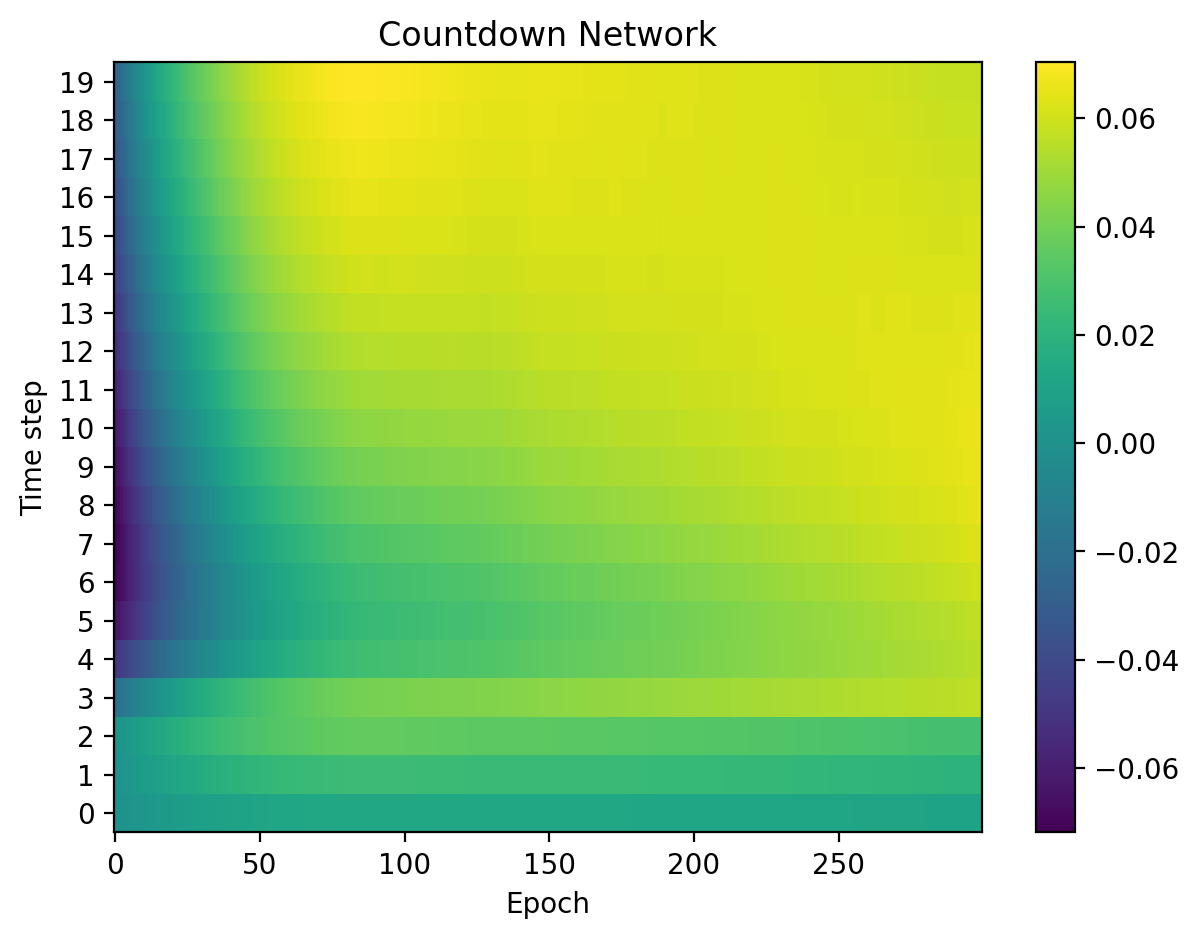

In [17]:
fig,ax=plt.subplots(figsize=(7,5))
im=ax.imshow(test_output,origin='lower',interpolation='nearest',aspect='auto')
ax.set_title("Countdown Network")
ax.set_xlabel("Epoch")
ax.set_ylabel("Time step")
ax.set_yticks(np.arange(timesteps))
cb = fig.colorbar(im)

Now: try to inspect output of LSTM neurons at intermediate times. This is also a nice example of how to use some smart keras functionality.

In [18]:
from tensorflow.keras import Model
# get a function that represents the mapping from the 
# network inputs to the neuron output values of the first LSTM layer:
neuron_values = Model([rnn.inputs], [firstLSTMlayer.output])

In [19]:
batchsize=1
test_observations,test_target=produce_batch_counting(batchsize, timesteps)

In [20]:
print(test_observations)

[[[1. 3.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]


In [21]:
the_values=neuron_values.predict_on_batch([test_observations])

/Users/rjn/miniforge3/envs/ml-env/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_8']]
Received: inputs=['Tensor(shape=(1, 20, 2))']
  warnings.warn(msg)


In [22]:
np.shape(the_values)

(1, 20, 2)

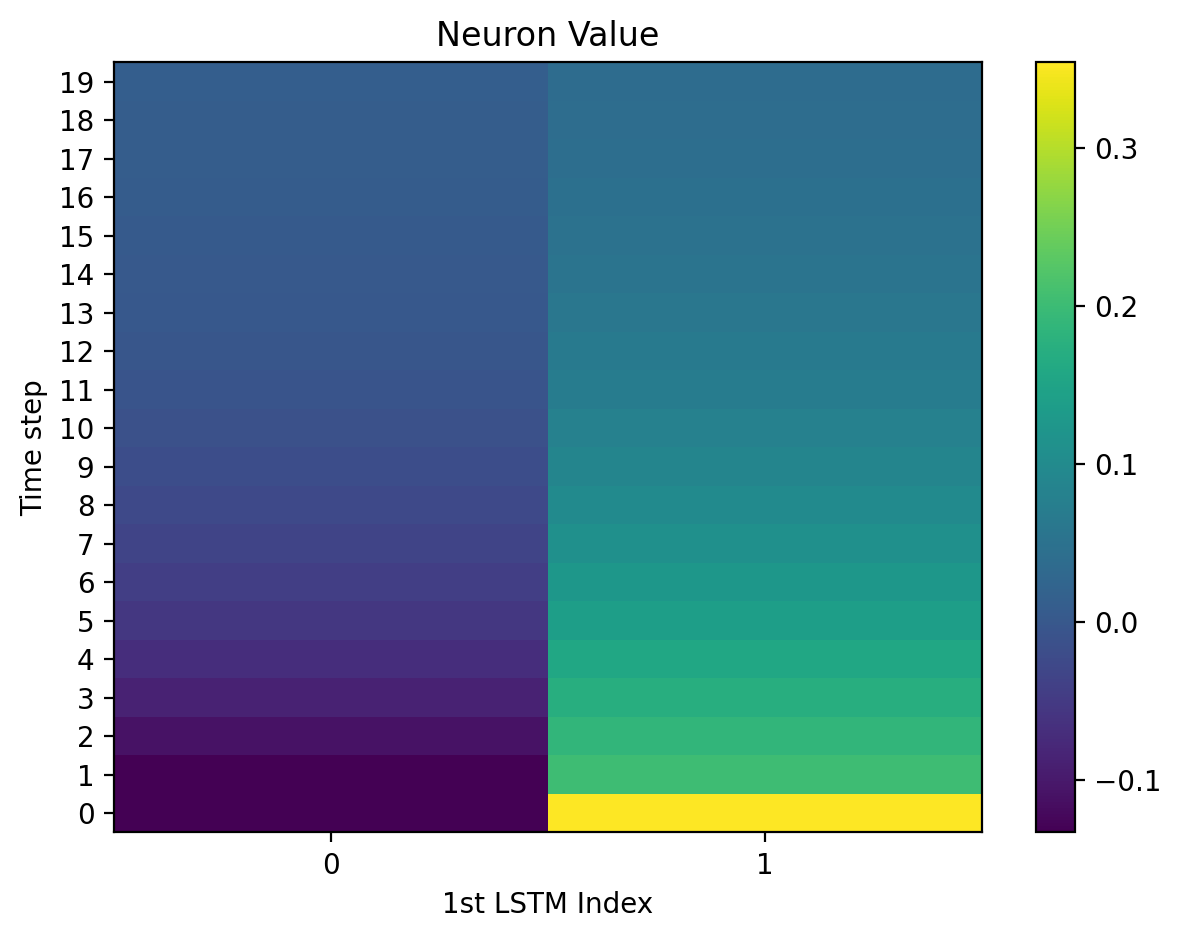

In [23]:
fig,ax=plt.subplots(figsize=(7,5))
im=ax.imshow(the_values[0,:,:],origin='lower',interpolation='nearest',aspect='auto')
ax.set_title("Neuron Value")
ax.set_xlabel("1st LSTM Index")
ax.set_ylabel("Time step")
ax.set_xticks([0,1])
ax.set_yticks(np.arange(timesteps))
cb = fig.colorbar(im)